# HR Dataset Machine Learning - Desafio Rocketmat 02 e Desafio extra

Esse notebook corresponde aos desafios 2 e extra da prova prática do processo seletivo para Estagiário em Ciência de Dados. Nele constam algumas propostas de problemas passíveis de ser resolvidos utilizando abordagens de machine learning e alguns experimentos realizados acerca de dois desses problemas e a interpretação dos modelos propostos.

O dataset utilizado traz dados sobre o RH de uma empresa. O dados podem ser encontrados no kaggle através do link a seguir: https://www.kaggle.com/krismurphy01/data-lab

A partir da observação dos dados disponível e das correlações, foi possível identificar alguns problemas que podem ser resolvidos utilizando técnincas de machine learning. Sendo eles:

* Previsão de saída do funcionário
* Previsão de desempenho do funcionário.
* Previsão de funcionários aptos a promoção (descartado).
* Previsão de identificação entre o funcionário e a empresa (descartado).
* Previsão de estresse com base em batimentos cardíacos (Não realizado). Dados de referência: https://www.tuasaude.com/frequencia-cardiaca/

Desses, foram desenvolvidos experimentos para o problema de classificação para a previsão de saída de funcionários e um problema de regressão para prever a avaliação de desempenho de funcionários. 

Para o problema de classificação foram utilizadas árvores de decisão e o random forest, trazendo duas abordagens para o mesmo problema. Como avaliação dos métodos foram utilizadas a Acurácia, o Kappa e a Área sobre a curva ROC. Para o problema de regressão foram utilizados os algoritimos de regressão linear, o regressor SVR e as árvores de decisão para regressão. A métrica utilizada foi o erro médio quadrado. Mais detalhes sobre essas aplicações serão mostrados mais a frente durante a experimentação. 

Os problemas seleção de funcionários (1) aptos a receberem uma promoção e de previsão da identificação do funcionário com a vaga (2) foram abandonados pelos seguintes motivos:
* Para o problema 1, os dados são extremamente desbalanceados, sendo que poucas amostras de pessoas que foram promovidas. Poderiam ser utilizadas algumas técnicas de balanceamento, entretanto, um aumento de dados na quantidade que seria necessária seria muito ruim para os resultados, uma vez que para aumentar utilizaríamos algum algoritmo para a criação de dados falsos com base nos dados presentes no dataset e esses dados falsos em excesso poderiam prejudicar na avaliação, poderiam não condizer com a realidade dos dados. Outra técnica seria um downsample, ou seja, selecionar da classe majoritária, aleatoriamente, a mesma quantidade de amostras da classe minoritária. Entretanto, essa segunda abordagem resultaria em uma quantidade mínima de amostras que seriam insuficientes para treinar os modelos. 
* Ainda no problema 1, as variáveis preditoras disponíveis para resolver o problema são insuficiente. Eu realizei o teste com os classificadores citados acima e obtive um resultado extremamente insatisfatório. 
* O problema 2 se trata de uma classificação multiclasse, cujo o resultado, com os dados disponíveis, não chegou a 50%. Talvez a disponibilidade de mais algumas variáveis de satisfação e de desempenho melhorassem o resultado. 

O problema de previsão de estresse ainda não foi avaliado nesse projeto, eu apenas fiz algumas pesquisas relacionadas ao tema. 

Essas propostas foram resolvidas utilizando abordagens simples para a seleção de features, entretanto, poderia ter sido utilizado algum método de redução de dimensionalidade como o PCA.

### Importação de Pacotes e visualização inicial dos dados 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, roc_auc_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression

pd.set_option('display.max_columns', 50)

In [2]:
data = pd.read_csv('./HR_data_to_ML.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head(10)

,Department,GEO,Role,Percent_Remote,last_evaluation,number_project,average_montly_hours,time_spend_company,left_Company,promotion_last_5years,salary,LinkedIn_Hits,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest),EMP_Sat_Remote_Mean,EMP_Engagement_Mean
0,Operations,US,VP,0.4,0.36,3,168,3,0,0,low,5,1,1,2,1,1841,61,9,2.4,4.2
1,Sales,UK,Senior Director,0.4,0.36,5,159,2,0,0,low,58,2,1,2,1,1990,90,8,2.4,4.2
2,Finance,France,Senior Director,0.4,0.36,2,282,3,0,0,medium,42,1,1,2,2,3193,80,8,2.4,4.2
3,Human Resources,China,Senior Director,0.4,0.36,4,278,4,0,0,high,37,2,1,2,1,3248,77,6,2.4,4.2
4,IT,Korea,Director,0.4,0.36,6,256,5,0,0,low,6,1,1,2,1,3149,80,10,2.4,4.2
5,Warehouse,Colombia,Director,0.4,0.36,4,97,4,0,0,medium,17,2,1,1,1,1204,85,10,2.4,4.2
6,Operations,Australia,Director,0.4,0.36,2,136,3,0,0,high,35,1,1,2,1,1801,70,10,2.4,4.2
7,Sales,Turkey,Director,0.4,0.36,4,128,4,0,0,medium,7,2,2,2,1,1940,86,6,2.4,4.2
8,Finance,Japan,Director,0.4,0.36,3,114,3,0,0,high,3,2,1,2,2,1974,64,7,2.4,4.2
9,Human Resources,UK,Director,0.4,0.36,2,137,4,0,0,medium,4,2,1,2,1,1185,63,8,2.4,4.2


### Conversão de variáveis categóricas

Algoritmos de machine learning não lidam muito bem com dados categóricos. Para trabalhar com esse tipo de dado é necessário realizar um processo de conversão desses dados, transformando o valor em texto da variável em etiquetas numéricas. Para tal, foi utilizado o algoritmo LabelEncoder.

In [3]:
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()

In [4]:
data[categorical_cols]

,Department,GEO,Role,salary
0,Operations,US,VP,low
1,Sales,UK,Senior Director,low
2,Finance,France,Senior Director,medium
3,Human Resources,China,Senior Director,high
4,IT,Korea,Director,low
...,...,...,...,...
14866,IT,France,Level 2-4,low
14867,Warehouse,Colombia,Level 2-4,low
14868,Operations,Australia,Level 2-4,medium
14869,Sales,China,Level 2-4,medium


In [5]:
categorical_vars = data[categorical_cols]
data = pd.concat([data, pd.get_dummies(categorical_vars)], axis=1)
data.drop(categorical_cols, axis=1, inplace=True)

Após a discretização dos valores, os dados ficaram assim:

In [6]:
data.head()

,Percent_Remote,last_evaluation,number_project,average_montly_hours,time_spend_company,left_Company,promotion_last_5years,LinkedIn_Hits,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest),EMP_Sat_Remote_Mean,EMP_Engagement_Mean,Department_Finance,Department_Human Resources,Department_IT,Department_Operations,Department_Sales,Department_Warehouse,GEO_Australia,GEO_China,GEO_Colombia,GEO_France,GEO_Japan,GEO_Korea,GEO_Turkey,GEO_UK,GEO_US,Role_Director,Role_Level 1,Role_Level 2-4,Role_Manager,Role_Senior Director,Role_Senior Manager,Role_VP,salary_high,salary_low,salary_medium
0,0.4,0.36,3,168,3,0,0,5,1,1,2,1,1841,61,9,2.4,4.2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,0.4,0.36,5,159,2,0,0,58,2,1,2,1,1990,90,8,2.4,4.2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,0.4,0.36,2,282,3,0,0,42,1,1,2,2,3193,80,8,2.4,4.2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.4,0.36,4,278,4,0,0,37,2,1,2,1,3248,77,6,2.4,4.2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0.4,0.36,6,256,5,0,0,6,1,1,2,1,3149,80,10,2.4,4.2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


Com esse tratamento feito, podemos rever aquelas correlações da primeira parte desse projeto para selecionar as features que melhor se relacionam com o problema e os modelos propostos. 

### Problema 01: Prevendo a saída de um funcionário

Aqui apresentamos o nosso primeiro experimento com uso de machine learning. Nesse problema, proponho a classificação de possível saídas de funcionários da empresa.

A primeira coisa a ser avaliada é a distribuição entre as classes e com isso podemos notar que o dataset está bem desbalanceado, mas, realizei o experimento mesmo assim, até pra ter um resultado de base.

In [7]:
data.left_Company.value_counts()

0    11373
1     3498
Name: left_Company, dtype: int64

Para esse problema, eu realizei 2 experimentos. No primeiro, eu selecionei apenas as variáveis que possuíam algum grau de correlação incluindo a variável **EMP_Engagement_Mean** que possui uma correlação negativa igual a 1, o que significa que os nosso modelos irão atingir um resultado máximo. Esse teste foi feito apenas para visualizar como essa correlação forte se comporta nos modelos. O conjunto de dados foi dividido em subsets de treino e teste em uma proporção de 70% para treino e 30% para teste. Como o dataset é grande, essa proporção resulta em quantidades de dados satisfatórias para cada conjunto. 

In [8]:
y = data['left_Company']
X = data[['Emp_Identity', 'Emp_Role', 'Emp_Position', 'Emp_Title', 'EMP_Engagement_Mean']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

O primeiro teste realizado foi utilizando uma árvore de decisão, abaixo são mostradas as etapas de treino, teste e avaliação do modelo.

In [10]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_predict_tree = tree.predict(X_test)

In [11]:
print("Avaliação do modelo DecisionTreeClassifier")
print("Acurácia: {}".format(tree.score(X_test, y_test)))
print("Kappa: {}".format(cohen_kappa_score(y_test, y_predict_tree)))
print("Área sobre a curva ROC: {}".format(roc_auc_score(y_test, y_predict_tree)))

Avaliação do modelo DecisionTreeClassifier
Acurácia: 1.0
Kappa: 1.0
Área sobre a curva ROC: 1.0


Aqui vemos a matriz de confusão do modelo, servindo mais como uma forma visual de analizar o modelo.

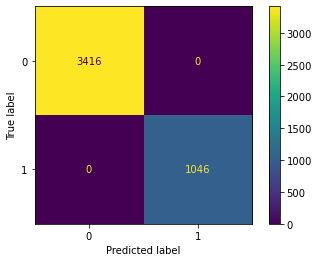

In [12]:
plot_confusion_matrix(tree, X_test, y_test);

Como esperado, o modelo obteve 100% em todas as métricas utilizadas e como já foi dito antes, isso se deve principalmente a variável de engajamento que possui uma forte correlação com a variável alvo desse problema. Isso pode ser analisado verificando o feature importance do modelo: 

In [13]:
columns = X.columns
feature_imp = tree.feature_importances_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance'])

,Feature,Importance
0,Emp_Identity,0.0
1,Emp_Role,0.0
2,Emp_Position,0.0
3,Emp_Title,0.0
4,EMP_Engagement_Mean,1.0


De acordo com a correlação, por ser negativa, e com essa informação do modelo, uma interpretação provável para esse problema é que o principal fator responsável pela demissão/saída de um funcionário é o engajamento e a participação dele em atividades da empresa. Quanto menos engajado nas atividades, maiores são as chances de um funcionário deixar a empresa.

Abaixo os testes com o RandomForest utilizando 10 estimadores:

In [14]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_predict_rf = tree.predict(X_test)

In [15]:
print("Avaliação do modelo RandomForestClassifier")
print("Acurácia: {}".format(rf.score(X_test, y_test)))
print("Kappa: {}".format(cohen_kappa_score(y_test, y_predict_rf)))
print("Área sobre a curva ROC: {}".format(roc_auc_score(y_test, y_predict_rf)))

Avaliação do modelo RandomForestClassifier
Acurácia: 1.0
Kappa: 1.0
Área sobre a curva ROC: 1.0


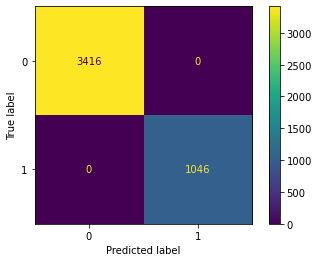

In [16]:
plot_confusion_matrix(rf, X_test, y_test);

No caso do Random Forest, as demais variáveis possuem alguma importância na definição do modelo, apesar de que aqui também a variável **EMP_Engagement_Mean** é a mais importante para o modelo.

In [17]:
columns = X.columns
feature_imp = rf.feature_importances_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance'])

,Feature,Importance
0,Emp_Identity,0.023800
1,Emp_Role,0.046723
2,Emp_Position,0.015568
3,Emp_Title,0.018894
4,EMP_Engagement_Mean,0.895015


Abaixo, uma tabela resumindo os resultados obtidos pelos 2 modelos criados:

In [18]:
pd.DataFrame({'Classificador': ['DecisionTree', 'RandomForestClassifier'], 
              'Acuracia': [tree.score(X_test, y_test), rf.score(X_test, y_test)],
              'Kappa': [cohen_kappa_score(y_test, y_predict_tree), cohen_kappa_score(y_test, y_predict_rf)],
              'ROC_AUC': [roc_auc_score(y_test, y_predict_tree), roc_auc_score(y_test, y_predict_rf)]},
              columns=['Classificador', 'Acuracia', 'Kappa', 'ROC_AUC'])

,Classificador,Acuracia,Kappa,ROC_AUC
0,DecisionTree,1.0,1.0,1.0
1,RandomForestClassifier,1.0,1.0,1.0


Os modelos treinados com as features com mais correlação obtiveram 100% de acerto em todas as métricas e em todos os modelos, com destaque especial a variável **EMP_Engagement_Mean**.

Com base no que foi observado acima, resolvi aplicar os mesmos testes para todos os dados do conjunto. Entretanto, a variável **EMP_Engagement_Mean** será eliminada do conjuntos. Com isso verificaremos os efeitos das outras features no modelo desconsiderando essa que já sabíamos que daria um excelente resultado. 

In [19]:
y = data['left_Company']
X = data.drop(['left_Company', 'EMP_Engagement_Mean'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Nos testes abaixo, sem a presença de variável de engajamento, é possível perceber uma pequena queda nos resultados, mas nada tão significativo. 

In [21]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_predict_tree = tree.predict(X_test)

In [22]:
print("Avaliação do modelo DecisionTreeClassifier")
print("Acurácia: {}".format(tree.score(X_test, y_test)))
print("Kappa: {}".format(cohen_kappa_score(y_test, y_predict_tree)))
print("Área sobre a curva ROC: {}".format(roc_auc_score(y_test, y_predict_tree)))

Avaliação do modelo DecisionTreeClassifier
Acurácia: 0.9901389511429852
Kappa: 0.9724724385071786
Área sobre a curva ROC: 0.9852686827481518


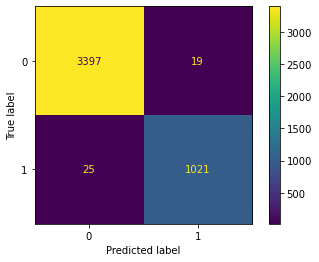

In [23]:
plot_confusion_matrix(tree, X_test, y_test);

As variáveis de maior importância para o modelo foram **Sensor_StepCount**, **average_montly_hours** e **number_project**. O alto número de passos do funcionário pode estar relacionado ao número de atividade que o funcionário faz, mas é difícil dizer, correlação e causalidade são coisas diferentes.  Esses resultados indicam que a média de horas de trabalho por mês e o número de projetos que o funcionário faz influenciam no fato de ele deixar ou não a empresa.

In [24]:
columns = X.columns
feature_imp = tree.feature_importances_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
11,Sensor_StepCount,0.514338
3,average_montly_hours,0.223599
2,number_project,0.167809
39,salary_medium,0.033408
1,last_evaluation,0.023174
0,Percent_Remote,0.020731
6,LinkedIn_Hits,0.003814
4,time_spend_company,0.002972
12,Sensor_Heartbeat(Average/Min),0.002359
9,Emp_Position,0.000873


In [25]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_predict_rf = tree.predict(X_test)

In [26]:
print("Avaliação do modelo RandomForestClassifier")
print("Acurácia: {}".format(rf.score(X_test, y_test)))
print("Kappa: {}".format(cohen_kappa_score(y_test, y_predict_rf)))
print("Área sobre a curva ROC: {}".format(roc_auc_score(y_test, y_predict_rf)))

Avaliação do modelo RandomForestClassifier
Acurácia: 0.9935006723442402
Kappa: 0.9724724385071786
Área sobre a curva ROC: 0.9852686827481518


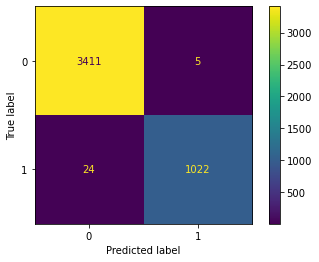

In [27]:
plot_confusion_matrix(rf, X_test, y_test);

Nessa abordagem com Random Forest, o número de projetos aparece como a feature de maior importância para o modelo. Além dela, a variável de última avaliação aparece entre as mais importantes, indicando que a avaliação do funcionário também influencia na classificação.

In [28]:
columns = X.columns
feature_imp = rf.feature_importances_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
11,Sensor_StepCount,0.227443
3,average_montly_hours,0.163564
2,number_project,0.115434
1,last_evaluation,0.108433
12,Sensor_Heartbeat(Average/Min),0.076760
4,time_spend_company,0.061049
8,Emp_Role,0.044386
0,Percent_Remote,0.043822
9,Emp_Position,0.024865
7,Emp_Identity,0.023847


Resumo dos resultados obtidos:

In [29]:
pd.DataFrame({'Classificador': ['DecisionTree', 'RandomForestClassifier'], 
              'Acuracia': [tree.score(X_test, y_test), rf.score(X_test, y_test)],
              'Kappa': [cohen_kappa_score(y_test, y_predict_tree), cohen_kappa_score(y_test, y_predict_rf)],
              'ROC_AUC': [roc_auc_score(y_test, y_predict_tree), roc_auc_score(y_test, y_predict_rf)]},
              columns=['Classificador', 'Acuracia', 'Kappa', 'ROC_AUC'])

,Classificador,Acuracia,Kappa,ROC_AUC
0,DecisionTree,0.990139,0.972472,0.985269
1,RandomForestClassifier,0.993501,0.972472,0.985269


Os resultados obtidos pelos dois classificadores foram: Acurácia de 99%, Kappa de 0.97 e uma Área sobre a curva ROC de 0.99 sendo um resultado excelente para esse problema, apesar do desbalanceamento do dataset e da retirada de uma variável importante. 

### Problema 02: Prevendo o desempenho de um funcionário

Para o segundo problema, foi posposta uma regressão para prever a avaliação dos funcionários. Para esse problema, a variável alvo utilizada para esse problema foi a variável **last_evaluation** e as variáveis preditoras selecionadas foram aquelas que obtiveram uma melhor correlação com a variável a ser predita.

In [30]:
y = data['last_evaluation']
X = data[['number_project', 'average_montly_hours', 'Percent_Remote', 'Emp_Identity', 'Emp_Role', 'Emp_Position', 'Emp_Title', 'Sensor_StepCount', 'Sensor_Heartbeat(Average/Min)', 'EMP_Engagement_Mean']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

O primeiro teste foi realizado utilizando uma regressão linear, abaixo o treino e a avaliação do modelomean_squared_error(y_pred_tree, y_test):

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [33]:
print("Avaliação do modelo LinearRegression")
print("Erro quadrado médio: {}".format(mean_squared_error(y_pred_lr, y_test)))

Avaliação do modelo LinearRegression
Erro quadrado médio: 0.0053465657372479495


O modelo obteve um erro quadrado médio de 0.005, sendo um resultado excelente. De acordo com a tabela abaixo, a coluna de maior peso no modelo foi o percentual de trabalho remoto do funcionário.

In [34]:
columns = X.columns
feature_imp = lr.coef_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
2,Percent_Remote,0.825219
9,EMP_Engagement_Mean,0.005891
8,Sensor_Heartbeat(Average/Min),0.000831
0,number_project,0.000337
1,average_montly_hours,0.000111
7,Sensor_StepCount,-0.000004
6,Emp_Title,-0.002154
4,Emp_Role,-0.002359
3,Emp_Identity,-0.004055
5,Emp_Position,-0.004851


Abaixo uma pequena visualização comparando os valores reais com os valores obtidos. É possível observar que os valores obtidos são bem próximos dos valores reais. 

In [35]:
pd.DataFrame({'y_real': y_test,
              'y_predito': y_pred_lr}, 
              columns=['y_real', 'y_predito']).head(15)

,y_real,y_predito
13989,0.97,0.857204
11890,0.89,0.868329
3485,0.55,0.548289
5733,0.64,0.554009
13328,0.94,0.857612
13670,0.96,0.885042
2991,0.54,0.555127
1713,0.50,0.558095
2993,0.54,0.561478
12181,0.90,0.838803


Abaixo, os mesmos processos são aplicados utilizando os modelos SVR e o DecisionTreeRegressor.

In [36]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [37]:
print("Avaliação do modelo SVR com kernel RBF")
print("Erro quadrado médio: {}".format(mean_squared_error(y_pred_svr, y_test)))

Avaliação do modelo SVR com kernel RBF
Erro quadrado médio: 0.011163444813099182


In [38]:
pd.DataFrame({'y_real': y_test,
              'y_predito': y_pred_svr}, 
              columns=['y_real', 'y_predito']).head(15)

,y_real,y_predito
13989,0.97,0.835981
11890,0.89,0.881111
3485,0.55,0.562812
5733,0.64,0.546430
13328,0.94,0.876539
13670,0.96,0.737999
2991,0.54,0.582379
1713,0.50,0.644209
2993,0.54,0.627896
12181,0.90,0.820416


In [39]:
tree_r = DecisionTreeRegressor()
tree_r.fit(X_train, y_train)
y_pred_tree = tree_r.predict(X_test)

In [40]:
print("Avaliação do modelo DecisionTreeRegressor")
print("Erro quadrado médio: {}".format(mean_squared_error(y_pred_tree, y_test)))

Avaliação do modelo DecisionTreeRegressor
Erro quadrado médio: 0.01033117436127297


Nesse modelo, a porcentagem de trabalho remoto também é a variável mais importante. Isso e a alta correlação me levam a acreditar que a porcentagem de trabalho que é feito remotamente influencia muito na avaliação do funcionário. Isso indica que profissionais que trabalham majoritariamente em casa obtém as maiores avaliações. 

In [41]:
columns = X.columns
feature_imp = tree_r.feature_importances_
pd.DataFrame({'Feature': columns,
              'Importance': feature_imp},
                columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

,Feature,Importance
2,Percent_Remote,0.814483
7,Sensor_StepCount,0.065757
1,average_montly_hours,0.045705
8,Sensor_Heartbeat(Average/Min),0.021923
0,number_project,0.014722
3,Emp_Identity,0.009680
5,Emp_Position,0.009619
6,Emp_Title,0.009110
4,Emp_Role,0.008644
9,EMP_Engagement_Mean,0.000356


In [42]:
pd.DataFrame({'y_real': y_test,
              'y_predito': y_pred_tree}, 
              columns=['y_real', 'y_predito']).head(15)

,y_real,y_predito
13989,0.97,0.81
11890,0.89,0.83
3485,0.55,0.50
5733,0.64,0.39
13328,0.94,0.89
13670,0.96,0.86
2991,0.54,0.48
1713,0.50,0.60
2993,0.54,0.60
12181,0.90,0.88


Abaixo, uma tabela com a comparação dos resultados obtidos nas três abordagens aplicadas ao problema.

In [43]:
pd.DataFrame({'Classificador': ['LinearRegression', 'SVR RBF', 'DecisionTreeRegression'], 
              'Erro quadrado médio': [mean_squared_error(y_pred_lr, y_test), mean_squared_error(y_pred_svr, y_test), mean_squared_error(y_pred_tree, y_test)]},
              columns=['Classificador', 'Erro quadrado médio'])

,Classificador,Erro quadrado médio
0,LinearRegression,0.005347
1,SVR RBF,0.011163
2,DecisionTreeRegression,0.010331


Para esse problema, o melhor resultado foi obtido pelo algoritmo LinearRegression com um erro de 0.005 que é um valor excelente, uma vez que problemas de regressão buscam reduzir o erro.

Outros testes e experimentações poderiam ser realizadas afim de avaliar melhores configurações de parâmetros dos modelos propostos para esses problemas, entretanto, os resultados obtidos são bem satisfatórios e trata-se de problemas bem simples que não necessitam de abordagens muito robustas. 